### Tu propia red neuronal con Numpy

En este notebook vamos a construir una red usando solamente numpy y nervios de acero. Será divertido.

<img src="frankenstein.png" style="width:20%">


* ref => https://towardsdatascience.com/building-an-artificial-neural-network-using-pure-numpy-3fe21acc5815

In [1]:
# librerias

import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
# usa modelos y datasets precargardos desde keras

download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Nuestra clase principal: una capa con metodos .forward() y .backward().

In [4]:
class Capa:
    '''
    Un bloque de construccion. Cada capa es capaz de realizar dos cosas:
    
    - Procesar la entrada para dar una salida:               salida = capa.forward(entrada)
    
    - Propagar los gradientes a traves de la propia capa:    grad_in = capa.backward(entrada, grad_out)
    
    Algunas capas tambien tienen parametros de aprendizaje que se actualizan durante el metodo capa.backward.
    '''
    def __init__(self):
        """Aqui se pueden inicializar parametros de la capa, si hay alguno, y cosas auxiliares."""
        # Una capa vacia no hace nada
        self.pesos = np.zeros(shape=(input.shape[1], 10))
        sesgos = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):  # propagacion hacia adelante de los datos
        '''
        Toma la dimension de los datos de entrada [muestra, unidades_entrada], 
        devuelve datos de salida [muestra, unidades_salida]
        '''
        # Una capa vacia solo devuelve la entrada.
        output = np.matmul(input, self.pesos) + sesgos  # multiplicacion matricial
        return output

    def backward(self, input, grad_output):  # propagacion hacia atras del error
        '''
        Realiza la propagacion hacia atras a traves de la capa, con respecto a la entrada dada.
        
        Se calculan los gradientes de la perdida de entrada, se necesita aplicar la regla de la cadena:
        
        d perdida / d x  = (d perdida / d capa) * (d capa / d x)
        
        Afortunadamente, se recibe d perdida / d capa como entrada, 
        asi que solo se necesita multiplicar por d capa / d x. (derivadas)
        
        Si na capa tiene parametro,por ejemplo una capa densa (full connected, dense),
        tambien se necesita actualizarla usando d perdida / d capa
        '''
        # El gradiente de una capa vacia es precisamente grad_output, pero se escribe explicitamente:
        num_unidades = input.shape[1]
        
        d_capa_d_entrada = np.eye(num_unidades)
        
        return np.dot(grad_output, d_capa_d_entrada) # regla de la cadena, producto escalar

### Camino por delante

Vamos a construir una red neuronal que clasifique números de la base de datos MNIST. Para hacerlo, necesitamos construir algunos bloques:

- Capa densa - capa fully-connected ,  $f(X)=W \cdot X + \vec{b}$
- Capa ReLU (unidad de rectificado lineal o otra capa no lineal que se prefiera)
- Funcion de perdida (entropia cruzada) (loss function - crossentropy)
- Algoritmo de propagacion hacia atras (Backprop algorithm), gradiente descente estocastico

Vamos a verlos uno por uno.


### Capa no lineal

Esta es la capa más simple que se puede tener: simplemente aplica una función no lineal a cada elemento de la red.

In [5]:
class ReLU(Capa):
    def __init__(self):
        '''ReLU aplica un rectificado lineal a todas las entradas'''
        pass
    
    def forward(self, input):
        '''Aplica ReLU elemento a elemento a la matriz [muestra, unidades_entrada]'''
        return np.maximum(0,input)
    
    def backward(self, input, grad_output):
        '''Calcula el gradiente de la perdida para las entradas de ReLU'''
        relu_grad = input > 0
        return grad_output*relu_grad        

In [6]:
# algunas pruebas

from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
num_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, num_grads, rtol=1e-3, atol=0),\
    'el gradiente devuelto por la capa no coincide con el gradiente calculado numericamente' 

#### En primer lugar: funciones lambda 

En python, se pueden definir funciones en una sola linea usando la funcion `lambda`,

que tiene una sintaxis tal que: `lambda param1, param2: expression`


Por ejemplo: `f = lambda x, y: x+y` es equivalente a la funcion:

```
def f(x,y):
    return x+y
```
Para mas informacion,  [aqui](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Capa densa (full connected)

Vamos a construir algo mas complicado. A diferencia de la no linealidad, una capa densa realmente aprende algo.

Una capa densa aplica una transformacion afin. En forma vectorial se puede describir:

$$f(X)= W \cdot X + \vec b $$

Donde 
* X es una matriz de caracteristicas de dimensiones [tamaño_muestra, num_caracteristicas],
* W es una matriz de pesos [num_caracteristicas, num_salidas] 
* b es un vector de sesgos [num_salidas].

Tanto W como b se inicializan durante la creacion de la capa y se actualizan cada vez que se llama al metodo backward().

In [7]:
class Densa(Capa):
    def __init__(self, in_unids, out_unids, tasa=0.1):
        '''
        Una capa densa es una capa que realiza una transformacion afin:
        f(x) = <W*x> + b
        tasa es la tasa de aprendizaje de la red (learning rate)
        '''
        self.tasa = tasa
        
        # inicializa los pesos con numeros pequeños aleatorios. Se usa un inicio normal, 
        # pero hay mejores maneras de hacerlo. Una vez que te funcione, prueba esto: http://bit.ly/2vTlmaJ
        self.pesos = np.random.randn(in_unids, out_unids)*0.01
        self.sesgos = np.zeros(out_unids)
        
    def forward(self,input):
        '''
        Realiza la transformacion afin:
        f(x) = <W*x> + b
        
        dimension de entrada: [muestra, unidades_entrada]
        dimension de salida: [muestra, unidades_salida]
        '''
        return np.matmul(input, self.pesos) + self.sesgos
    
    def backward(self,input,grad_output):
        
        # se calcula d f / d x = d f / d densa * d densa / d x
        # donde d densa/ d x = matriz de pesos traspuesta
        grad_input = np.dot(grad_output,np.transpose(self.pesos))
        
        # se calcula el gradiente de los pesos y los sesgos
        grad_pesos = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_sesgos = np.sum(grad_output, axis = 0)
        
        assert grad_pesos.shape == self.pesos.shape and grad_sesgos.shape == self.sesgos.shape
        # Aqui se realiza el paso de gradiente descente estocastico. 
        # Despues, puedes intentar mejorarlo.
        self.pesos = self.pesos - self.tasa * grad_pesos
        self.sesgos = self.sesgos - self.tasa * grad_sesgos
        
        return grad_input

### Testeando la capa densa

Se haran algunos tests para asegurarnos que la capa densa funciona adecuadamente. Si funciona, se printea ¡Bien hecho!

... o no, y tendras que arreglar algo. Para esto alguno consejos:
* Asegurate de calcular los gradientes para pesos y sesgo como __la suma de los gradientes sobre la muestra__. La salida ya está dividida entre el tamaño de la muestra.
* Si estás debbugueando, procura guardar los gradientes en una clase, como "self.grad_w = grad_w" o printea los primeros pesos. Esto ayuda.
* Si nada ayuda, trata de ignorar el test y pasa a la fase de entrenamiento. Si entrena, está pasando algo que no afecta al funcionamiento de la red.

In [8]:
l = Densa(128, 150)

assert -0.05 < l.pesos.mean() < 0.05 and 1e-3 < l.pesos.std() < 1e-1,\
    'Los pesos iniciales deben tener media cero y poca varianza.'\
    'Si sabes lo que haces, borra este assert.'

assert -0.05<l.sesgos.mean()<0.05, 'Los sesgos deben tener media cero. Ignora esto si por alguna razón pones otra cosa'


# Para testear las salidas, explicitamente se ponen valores fijos. ¡NO HACER ESTO CON LA RED REAL!
l = Densa(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.pesos = np.linspace(-1,1,3*4).reshape([3,4])
l.sesgos = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print('¡Bien hecho!')

¡Bien hecho!


In [9]:
# Para testear los gradientess, usamos los gradientes obtenidos por diferencias finitas

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Densa(32, 64, tasa=0)

num_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads, num_grads, rtol=1e-3, atol=0), \
                   'el gradiente de entrada no cuadra con el gradiente numerico'
print('¡Bien hecho!')

¡Bien hecho!


In [10]:
#testeo de gradientes con parametros

def salida_dados_ps(p,s):
    capa = Densa(32, 64, tasa=1)
    capa.pesos = np.array(p)
    capa.sesgos = np.array(s)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return capa.forward(x)
    
def grad_por_params(p,s):
    capa = Densa(32, 64, tasa=1)
    capa.pesos = np.array(p)
    capa.sesgos = np.array(s)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    capa.backward(x,np.ones([10,64]) / 10.)
    return  p-capa.pesos, s-capa.sesgos
    
p,s = np.random.randn(32,64), np.linspace(-1,1,64)

num_dp = eval_numerical_gradient(lambda p: salida_dados_ps(p,s).mean(0).sum(),p)
num_ds = eval_numerical_gradient(lambda s: salida_dados_ps(p,s).mean(0).sum(),s)

grad_p, grad_s = grad_por_params(p,s)

assert np.allclose(num_dp, grad_p, rtol=1e-3, atol=0), 'los pesos del gradiente no concuerdan con el valor numerico'
assert np.allclose(num_ds, grad_s, rtol=1e-3, atol=0), 'los pesos del gradiente no concuerdan con el valor numerico'
print('¡Bien hecho!')

¡Bien hecho!


### La funcion de perdida (loss function)

Dado que queremos predecir probabilidades, seria logico definir la funcion softmax en la red y computar la funcion de perdida dadas las probabilidades predichas. Sin embargo, existe una manera mejor de hacer esto.

Escribiendo la expresion de la entropia cruzada como funcion de los logits de la funcion softmax, se veria algo como:

$$ perdida = - log \space {e^{a_{correcto}} \over {\underset i \sum e^{a_i} } } $$

Mirando mas profundamente, se puede reescribir como:

$$ perdida = - a_{correcto} + log {\underset i \sum e^{a_i} } $$

A esto se le llama Log-softmax y es mejor que hacer directamente log(softmax(a)) en todos los aspectos:
* Mejor estabilidad numerica
* Mas facil de derivar
* Computacion mas rapida


Usaremos log-softmax.

In [11]:
def softmax(logits,respuestas):
    '''Calcula la entropia cruzada desde logits[muestra,n_clases] y las ids de la respuesta correcta'''
    logits_respuestas = logits[np.arange(len(logits)), respuestas]
    
    x_entropia = -logits_respuestas + np.log(np.sum(np.exp(logits),axis=-1))
    
    return x_entropia

def grad_softmax(logits,respuestas):
    '''
    Calcula los gradientes de la entropia cruzada desde logits[muestra,n_clases] 
    y las ids de la respuesta correcta
    '''
    unos_respuestas = np.zeros_like(logits)
    unos_respuestas[np.arange(len(logits)),respuestas] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (-unos_respuestas + softmax) / logits.shape[0]

In [12]:
logits = np.linspace(-1,1,500).reshape([50,10])
respuestas = np.arange(50)%10

softmax(logits,respuestas)
grads = grad_softmax(logits,respuestas)
num_grads = eval_numerical_gradient(lambda x: softmax(x, respuestas).mean(),logits)

assert np.allclose(num_grads, grads, rtol=1e-3, atol=0), 'La implementacion ha fallado.'

### Red completa

Ahora vamos a combinar todo para construir una red neuronal funcional. Se usara para clasificar numeros escritos a mano, asi que lo primero cargar los datos.

Using TensorFlow backend.


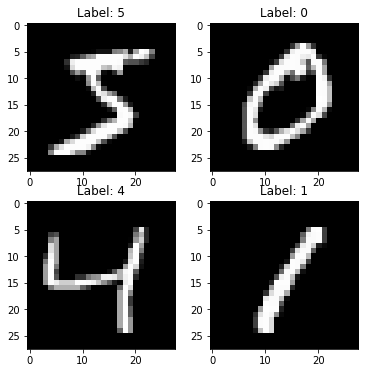

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # quita avisos

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

Definiremos la red como una lista de capas, cada aplicada a la salida de la anterior. Con esta configuracion, calcular las predicciones se vuelve trivial.

In [14]:
red = []
red.append(Densa(X_train.shape[1],100))
red.append(ReLU())
red.append(Densa(100,200))
red.append(ReLU())
red.append(Densa(200,10))

In [15]:
def forward(red, X):
    '''
    Calcula las activaciones de todas las capas de la red aplicandolas secuencialmente.
    Devuelve una lista de activaciones para cada capa. 
    Asegurate que las ultimas activaciones corresponden a los logits.
    '''
    activaciones = []
    input = X

    for i in range(len(red)):
        activaciones.append(red[i].forward(X))
        X = red[i].forward(X)
        
    assert len(activaciones) == len(red)
    return activaciones



def predice(red, X):
    '''
    Calcula las predicciomnes de la red.
    '''
    logits = forward(red, X)[-1]
    return logits.argmax(axis=-1)



def train(red, X, y):
    '''
    Entrena la red en una muestra dada de X e y.
    Primero forward para tener todas las activaciones.
    Luego capa.backward desde la ultima a la primera, una vez que se tiene el backward
    para todas las capas, ya se ha hecho un paso del gradiente.
    '''
    
    # Se obtienen las activaciones
    activaciones = forward(red, X)
    #entradas_capa = [X]+activaciones  #entradas_capa[i] es una entrada par red[i]
    logits = activaciones[-1]
    
    # Se calcula la perdida y el gradiente inicial
    perdida = softmax(logits, y)
    grad_perdida = grad_softmax(logits, y)
    
    for i in range(1, len(red)):
        grad_perdida = red[len(red) - i].backward(activaciones[len(red) - i - 1], grad_perdida)
        
    return np.mean(perdida)

En vez de testear, hacemos el print del acierto de entrenamiento y validacion en cada epoca.

Si la implementacion es correcta, el acierto deberia estar entre el 90~93% a >97% con la red por defecto.

### Bucle de entrenamiento

Como es usual, se separa en pequeñas muestras para alimentar la red y actualizar los pesos.

In [16]:
def muestras(entradas, objetivos, batch, shuffle=False):
    assert len(entradas) == len(objetivos)
    if shuffle:
        indices = np.random.permutation(len(entradas))
    for idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(entradas) - batch + 1, batch)):
        if shuffle:
            excerpt = indices[idx:idx + batch]
        else:
            excerpt = slice(idx, idx + batch)
        yield entradas[excerpt], objetivos[excerpt]

In [17]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoca 24
Acierto entrenamiento: 0.89598
Acierto validacion: 0.9045


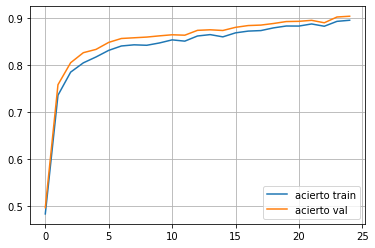

In [18]:
for epoca in range(25):

    for x_batch, y_batch in muestras(X_train, y_train, batch=32,shuffle=True):
        train(red, x_batch, y_batch)
    
    train_log.append(np.mean(predice(red, X_train) == y_train))
    val_log.append(np.mean(predice(red, X_val) == y_val))
    
    clear_output()
    print('Epoca',epoca)
    print('Acierto entrenamiento:',train_log[-1])
    print('Acierto validacion:',val_log[-1])
    plt.plot(train_log,label='acierto train')
    plt.plot(val_log,label='acierto val')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

### Tarea de revision


#### Opcion I: inicializacion
* Implementar una capa Densa con inicializacion de Xavier explicada [aqui](http://bit.ly/2vTlmaJ)

Para realizar esta tarea, se debe hacer un experimento mostrando como funciona la inicializacion de Xavier en comparacion con la inicializacion por defecto en redes profundas (5+ capas).


#### Opcion II: regularizacion
* Implementar una version de la capa Densa con regularizacion L2: cuando se actualizan los pesos de una capa, se ajusta el gradiente a minimizar

$$ Perdida = Entropia_cruzada + \alpha \cdot \underset i \sum {w_i}^2 $$

Para realizar esta tarea, se debe hacer un experimento mostrando si la regularizacion mitiga el sobreajuste en el caso de tener un gran numero de neuronas. Considerar ajustar $\alpha$ para mejores resultados.

#### Opcion III: optimizacion
* Implementar una version de la capa Densa que use momentum/rmsprop o cualquier metodo que haya funcionado mejor la ultima vez.

Most of those methods require persistent parameters like momentum direction or moving average grad norm, but you can easily store those params inside your layers.

To pass this assignment, you must conduct an experiment showing how your chosen method performs compared to vanilla SGD.

### General remarks
_Please read the peer-review guidelines before starting this part of the assignment._

In short, a good solution is one that:
* is based on this notebook
* runs in the default course environment with Run All
* its code doesn't cause spontaneous eye bleeding
* its report is easy to read.

_Formally we can't ban you from writing boring reports, but if you bored your reviewer to death, there's noone left alive to give you the grade you want._


### Bonus assignments

As a bonus assignment (no points, just swag), consider implementing Batch Normalization ([guide](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)) or Dropout ([guide](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)). Note, however, that those "layers" behave differently when training and when predicting on test set.

* Dropout:
  * During training: drop units randomly with probability __p__ and multiply everything by __1/(1-p)__
  * During final predicton: do nothing; pretend there's no dropout
  
* Batch normalization
  * During training, it substracts mean-over-batch and divides by std-over-batch and updates mean and variance.
  * During final prediction, it uses accumulated mean and variance.
